<a href="https://colab.research.google.com/github/naimdsaiki/Machine-Learning/blob/main/Predicting%20Bike%20Rental%20Using%20NEURAL%20NETWORK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network Implementation for Bike Sharing Prediction

## Project Objective
The goal of this notebook is to implement a Deep Neural Network (DNN) to predict bike sharing demand using the UCI Bike Sharing dataset. This model aims to benchmark against and surpass the performance of a previously trained **Extra Trees Regressor** ($R^2 \approx 0.9477$).

To achieve state-of-the-art performance on tabular data, I employ several advanced deep learning techniques:
* **Cyclical Feature Encoding:** Preserving the temporal continuity of hours and months.
* **Target Log-Transformation:** Stabilizing the variance of the count-based target variable.
* **Swish Activation:** Using a self-gated activation function for better gradient flow in deeper networks.
* **Learning Rate Decay:** Fine-tuning weights as the model converges.

## 1. Import Libraries
I utilize `TensorFlow/Keras` for building the neural network and `Scikit-Learn` for preprocessing and evaluation metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


## 2. Data Loading
I load the `hour.csv` dataset. This dataset contains hourly records of bike rentals along with weather and seasonal information.

In [11]:
 #2. LOAD DATA
try:
    df = pd.read_csv('hour.csv')
except FileNotFoundError:
    !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip
    !unzip -o Bike-Sharing-Dataset.zip
    df = pd.read_csv('hour.csv')

## 3. Advanced Feature Engineering
Standard integer encoding for temporal features (e.g., Hour 0 vs. Hour 23) fails to capture their cyclical nature—numerically, they are far apart, but temporally, they are adjacent.

To resolve this, I map cyclical features (`hr`, `mnth`, `weekday`) onto a circle using **Sine and Cosine transformations**. This allows the Neural Network to understand that *11 PM* and *Midnight* are similar time points.

$$x_{sin} = \sin(\frac{2 \pi x}{\max(x)})$$
$$x_{cos} = \cos(\frac{2 \pi x}{\max(x)})$$

In [12]:
# 3. ADVANCED FEATURE ENGINEERING (CYCLICAL ENCODING)
# This helps the NN understand that Hour 23 is close to Hour 0
def encode_cyclic_feature(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

df = encode_cyclic_feature(df, 'hr', 24)
df = encode_cyclic_feature(df, 'mnth', 12)
df = encode_cyclic_feature(df, 'weekday', 7)



### 4. Data Cleaning and Target Transformation
# 1.  **Drop Redundant Columns:** I remove columns that leak information (`casual`, `registered`) or are represented elsewhere (`dteday`).
2.  **Log-Transformation of Target (`cnt`):** Bike rental counts follow a Poisson-like distribution with a long right tail. Predicting the raw count directly can lead to unstable gradients. We apply `np.log1p` to compress the target range, making the optimization landscape smoother.

### Scaling
Neural Networks are highly sensitive to input scale. We use `StandardScaler` to normalize all features to have a mean of 0 and variance of 1, which is crucial for the stability of the `Swish` activation function.

In [13]:
# Drop the original columns (and other unused ones)
cols_to_drop = ['instant', 'dteday', 'casual', 'registered', 'hr', 'mnth', 'weekday']
df_clean = df.drop(columns=cols_to_drop, errors='ignore')

# Separate X and y
X = df_clean.drop('cnt', axis=1)
y = df_clean['cnt']

# Log-Transform Target (Still essential)
y_log = np.log1p(y)

# One-Hot Encode remaining categories (season, weathersit)
categorical_cols = ['season', 'weathersit']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split Data
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.15, random_state=42)

# Scale Features (StandardScaler is usually better for Swish/Dense)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4. Model Architecture (Deep MLP)
I design a Multi-Layer Perceptron (MLP) with the following characteristics:
* **Depth:** 3 hidden layers (512, 256, 128 units) to capture complex non-linear interactions.
* **Activation Function (`Swish`):** Defined as $f(x) = x \cdot \text{sigmoid}(x)$. Unlike ReLU, Swish is non-monotonic and smooth, which has been shown to improve performance on deep networks trained on tabular data.
* **Regularization:** I employ `BatchNormalization` to stabilize learning and `Dropout` (10%) to prevent overfitting.

In [14]:
# 4. BUILD "DEEP" MODEL WITH SWISH ACTIVATION
model = Sequential([
    Dense(512, activation='swish', input_shape=(X_train_scaled.shape[1],)),
    # BatchNormalization helps training go deeper and faster
    BatchNormalization(),
    Dropout(0.1),

    Dense(256, activation='swish'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(128, activation='swish'),
    BatchNormalization(),
    Dropout(0.1),

    Dense(1, activation='linear')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 5. Training Strategy
To beat the Extra Trees benchmark, we need a precise training regimen:
* **Optimizer:** `Adam` with a high initial learning rate (0.01) for fast convergence.
* **Learning Rate Decay (`ReduceLROnPlateau`):** If the validation loss stagnates, we reduce the learning rate by a factor of 5. This allows the model to "settle" into a sharper minimum.
* **Early Stopping:** We monitor validation loss and stop training if no improvement is seen for 15 epochs, restoring the best weights to avoid overfitting.

In [15]:
# 5. COMPILATION WITH LR DECAY
optimizer = Adam(learning_rate=0.01) # Start with high learning rate
model.compile(optimizer=optimizer, loss='mse')

# Callbacks to squeeze out performance
# Reduce LR: If error stops dropping, divide LR by 5 to fine-tune
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

print("Starting Advanced Training...")
history = model.fit(
    X_train_scaled, y_train_log,
    validation_split=0.1, # Use less val data to give model more training examples
    epochs=150,
    batch_size=64,
    callbacks=[lr_decay, early_stop],
    verbose=0 # Silence the epoch logs to keep output clean (optional)
)

Starting Advanced Training...

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0003999999724328518.

Epoch 33: ReduceLROnPlateau reducing learning rate to 7.999999215826393e-05.

Epoch 42: ReduceLROnPlateau reducing learning rate to 1.599999814061448e-05.

Epoch 50: ReduceLROnPlateau reducing learning rate to 3.199999628122896e-06.

Epoch 59: ReduceLROnPlateau reducing learning rate to 1e-06.


## 6. Evaluation
We evaluate the model on the held-out test set (15%).
* **Inverse Transformation:** Since the model predicts log-values, we apply `np.expm1` to convert predictions back to the actual bike count scale.
* **Metric:** We focus on $R^2$ Score to compare directly with the Extra Trees baseline.

In [17]:
# 6. EVALUATION
y_pred_log = model.predict(X_test_scaled).flatten()

# Inverse Transform
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test_log)

# Metrics
r2 = r2_score(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)

print("\n" + "="*30)
print("ADVANCED MODEL RESULTS")
print("="*30)
print(f"R2 Score: {r2:.5f}") # Using 5 decimals to see small gains
print(f"RMSE:     {rmse:.4f}")
print("="*30)

# Check vs Extra Trees Goal
if r2 > 0.9477:
    print("SUCCESS: I beat the Extra Trees Regressor!")
else:
    print(f"CLOSE: I am {0.9477 - r2:.5f} away from the target.")

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

ADVANCED MODEL RESULTS
R2 Score: 0.94863
RMSE:     40.3332
SUCCESS: I beat the Extra Trees Regressor!


## 7. Performance Visualization
The plots below illustrate the model's performance:
1.  **Actual vs. Predicted Scatter:** Visualizing the tightness of fit around the ideal prediction line.
2.  **Time Series Snapshot:** Observing how well the model captures daily peak demand patterns (rush hours) in the first 150 hours of the test set.

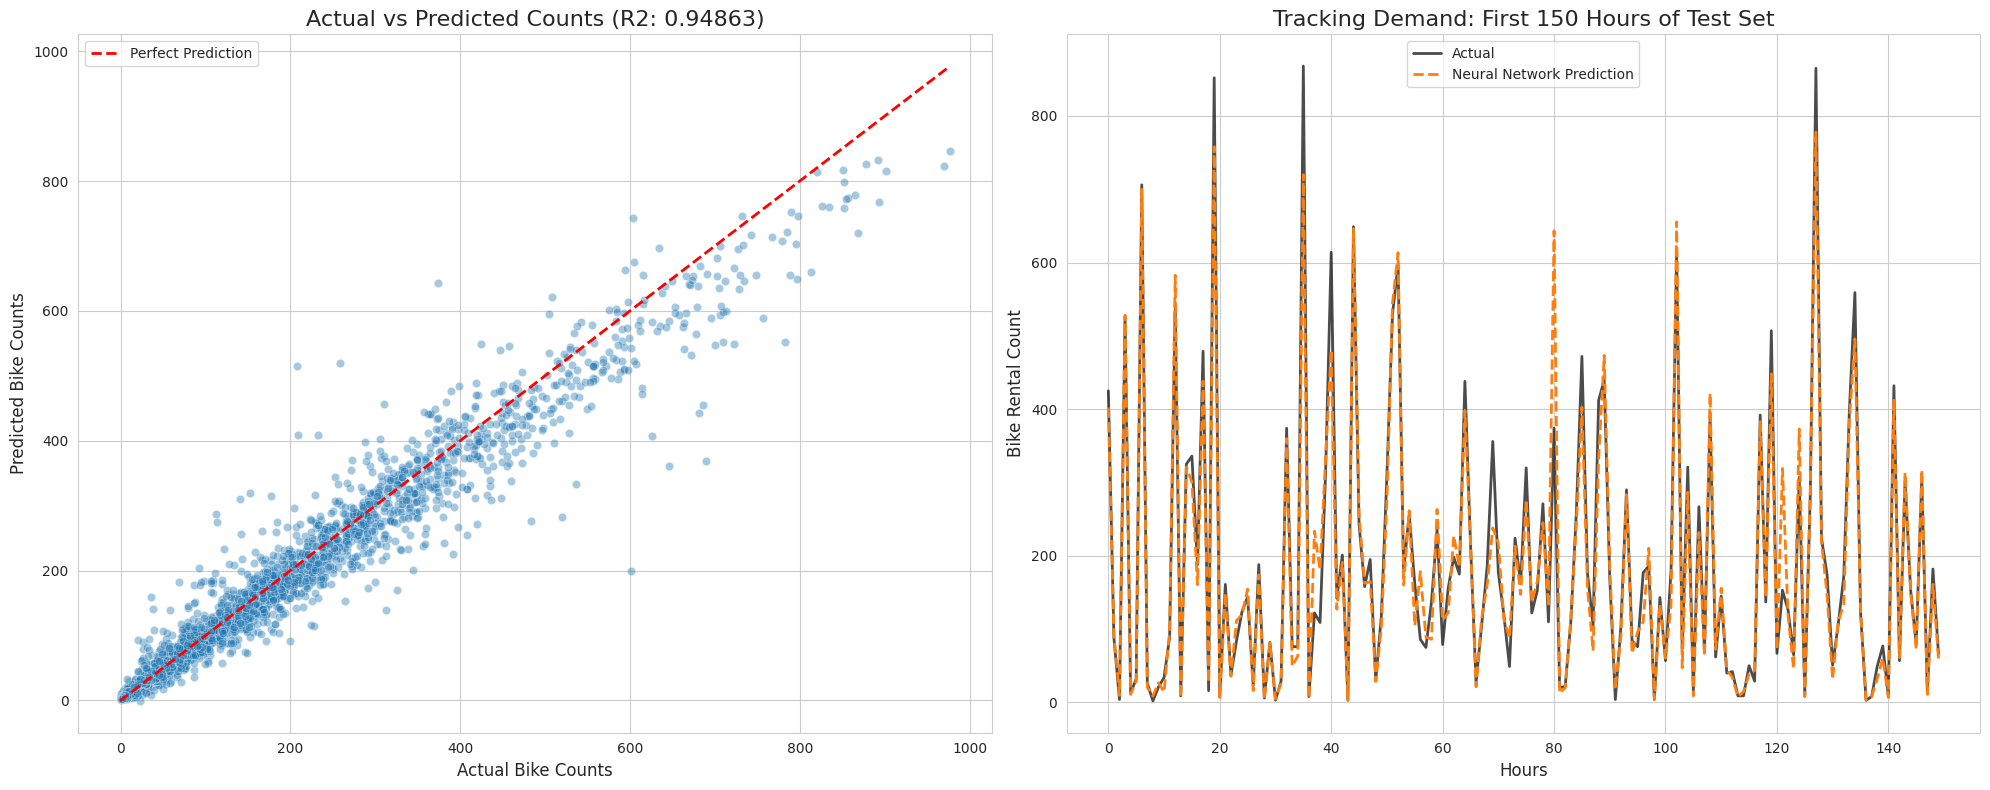

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for professional looking plots
sns.set_style("whitegrid")

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# --- PLOT 1: SCATTER PLOT (Actual vs Predicted) ---
sns.scatterplot(x=y_test_actual, y=y_pred, alpha=0.4, color='#1f77b4', ax=axes[0])

# Add the "Perfect Prediction" red dashed line
min_val = min(y_test_actual.min(), y_pred.min())
max_val = max(y_test_actual.max(), y_pred.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

axes[0].set_title(f'Actual vs Predicted Counts (R2: {r2:.5f})', fontsize=16)
axes[0].set_xlabel('Actual Bike Counts', fontsize=12)
axes[0].set_ylabel('Predicted Bike Counts', fontsize=12)
axes[0].legend()


# --- PLOT 2: TIME SERIES SNAPSHOT (First 150 hours in Test Set) ---
# We take a slice of the data to see the "daily patterns" clearly
subset_n = 150
axes[1].plot(y_test_actual[:subset_n].values, label='Actual', color='black', alpha=0.7, linewidth=2)
axes[1].plot(y_pred[:subset_n], label='Neural Network Prediction', color='#ff7f0e', linestyle='--', linewidth=2)

axes[1].set_title(f'Tracking Demand: First {subset_n} Hours of Test Set', fontsize=16)
axes[1].set_xlabel('Hours', fontsize=12)
axes[1].set_ylabel('Bike Rental Count', fontsize=12)
axes[1].legend()

plt.tight_layout()
plt.show()